In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [2]:
data_dict = {#"$CPI$":"CPIAUCNS",
             "B": "BOGMBASE",
             "NGDP":"GDP",
             "C":"CURRCIR",
             "A":"WALCL"}

rate_dict = {"UST10Y": "DGS10",
             "EFFR": "DFF",
            "$\\frac{Debt}{GDP}$":"FYGFGDQ188S"}

freq = "Q"
start = datetime.datetime(1950, 1, 1)
# end = datetime.datetime(1985, 12, 31)
end =datetime.datetime.today()

data = gather_data(data_dict, start, 
          end = end, freq = freq)
rate_data = gather_data(rate_dict, start, 
          end = end, freq = freq) / 100
# df["Nominal GDP"] = df["Nominal GDP"].mul(1000)
# df["Real GDP"] = df["Real GDP"].mul(1000)

In [3]:
log_data = data.copy()
log_vars = data_dict.keys()
for log_var in log_vars:
    log_data[log_var] = np.log(log_data[log_var])
log_data

,B,NGDP,C,A
DATE,,,,
1959-03-31,10.819778,6.235058,3.443991,NaN
1959-06-30,10.823106,6.258918,3.450876,NaN
1959-09-30,10.834338,6.263463,3.466319,NaN
1959-12-31,10.840234,6.270232,3.475377,NaN
1960-03-31,10.818444,6.296461,3.457893,NaN
...,...,...,...,...
2022-12-31,15.499784,10.181438,7.736954,15.973106
2023-03-31,15.503273,10.196665,7.742011,15.954423
2023-06-30,15.536561,10.205923,7.754952,15.952583


In [4]:
freq = 4 * 1
for diff_var in log_vars:
    rate_data[diff_var] = log_data[diff_var].diff(freq)#.mul(100)
diff_rate_data = rate_data.diff(freq)

In [5]:
rate_data

,UST10Y,EFFR,$\frac{Debt}{GDP}$,B,NGDP,C,A
DATE,,,,,,,
1962-03-31,0.040163,0.024583,NaN,0.030377,0.086082,0.032667,NaN
1962-06-30,0.038757,0.026071,NaN,0.039642,0.077590,0.040858,NaN
1962-09-30,0.039895,0.028451,NaN,0.037765,0.070333,0.040893,NaN
1962-12-31,0.039025,0.029240,NaN,0.022151,0.053107,0.038187,NaN
1963-03-31,0.038921,0.029657,NaN,0.022355,0.045511,0.040504,NaN
...,...,...,...,...,...,...,...
2023-03-31,0.036463,0.045146,0.921727,-0.119335,0.068869,0.027335,-0.045771
2023-06-30,0.035957,0.049881,0.941583,-0.012556,0.057755,0.026002,-0.052894
2023-09-30,0.041497,0.052592,0.954342,0.006873,0.060292,0.024018,-0.081071


In [6]:
diff_rate_data.to_csv("C://Users/jlcat/Documents/For NDSU/EnrichmentCourses/DataScienceCertificate/STAT712/NGDPData.csv")

In [7]:
keys = log_vars
annual_rate = data.copy()
quarterly_rate = data.copy()
for key in keys:
#     if "PPI" in key or "CPI" in key or "M2" in key:
    annual_rate[key] = data[key].pct_change(freq ) * 100
    quarterly_rate[key] = ((data[key].pct_change(1)).add(1)).pow(freq ).sub(1).mul(100)

for key in keys:
    if "Rate" in key or "UST" in key:
        annual_rate[key] = data[key]
        quarterly_rate[key] = data[key]
        
diff_annual_rate = annual_rate.diff(freq)

In [8]:
annual_rate

,B,NGDP,C,A
DATE,,,,
1959-03-31,NaN,NaN,NaN,NaN
1959-06-30,NaN,NaN,NaN,NaN
1959-09-30,NaN,NaN,NaN,NaN
1959-12-31,NaN,NaN,NaN,NaN
1960-03-31,-0.133333,6.332765,1.399904,NaN
...,...,...,...,...
2022-12-31,-15.534493,7.113487,3.566016,0.154729
2023-03-31,-11.248919,7.129637,2.771237,-4.473948
2023-06-30,-1.247711,5.945517,2.634257,-5.151955


,UST10Y,EFFR,$\frac{Debt}{GDP}$,B,NGDP,C,A
UST10Y,1.000000,0.609968,-0.286544,-0.148743,0.220753,-0.087434,-0.339417
EFFR,0.609968,1.000000,-0.334203,-0.201679,0.193318,-0.179355,-0.466848
$\frac{Debt}{GDP}$,-0.286544,-0.334203,1.000000,0.437286,-0.302540,0.445425,0.546481
B,-0.148743,-0.201679,0.437286,1.000000,-0.370616,0.611558,0.895813
NGDP,0.220753,0.193318,-0.302540,-0.370616,1.000000,-0.145117,-0.604560
C,-0.087434,-0.179355,0.445425,0.611558,-0.145117,1.000000,0.754129
A,-0.339417,-0.466848,0.546481,0.895813,-0.604560,0.754129,1.000000


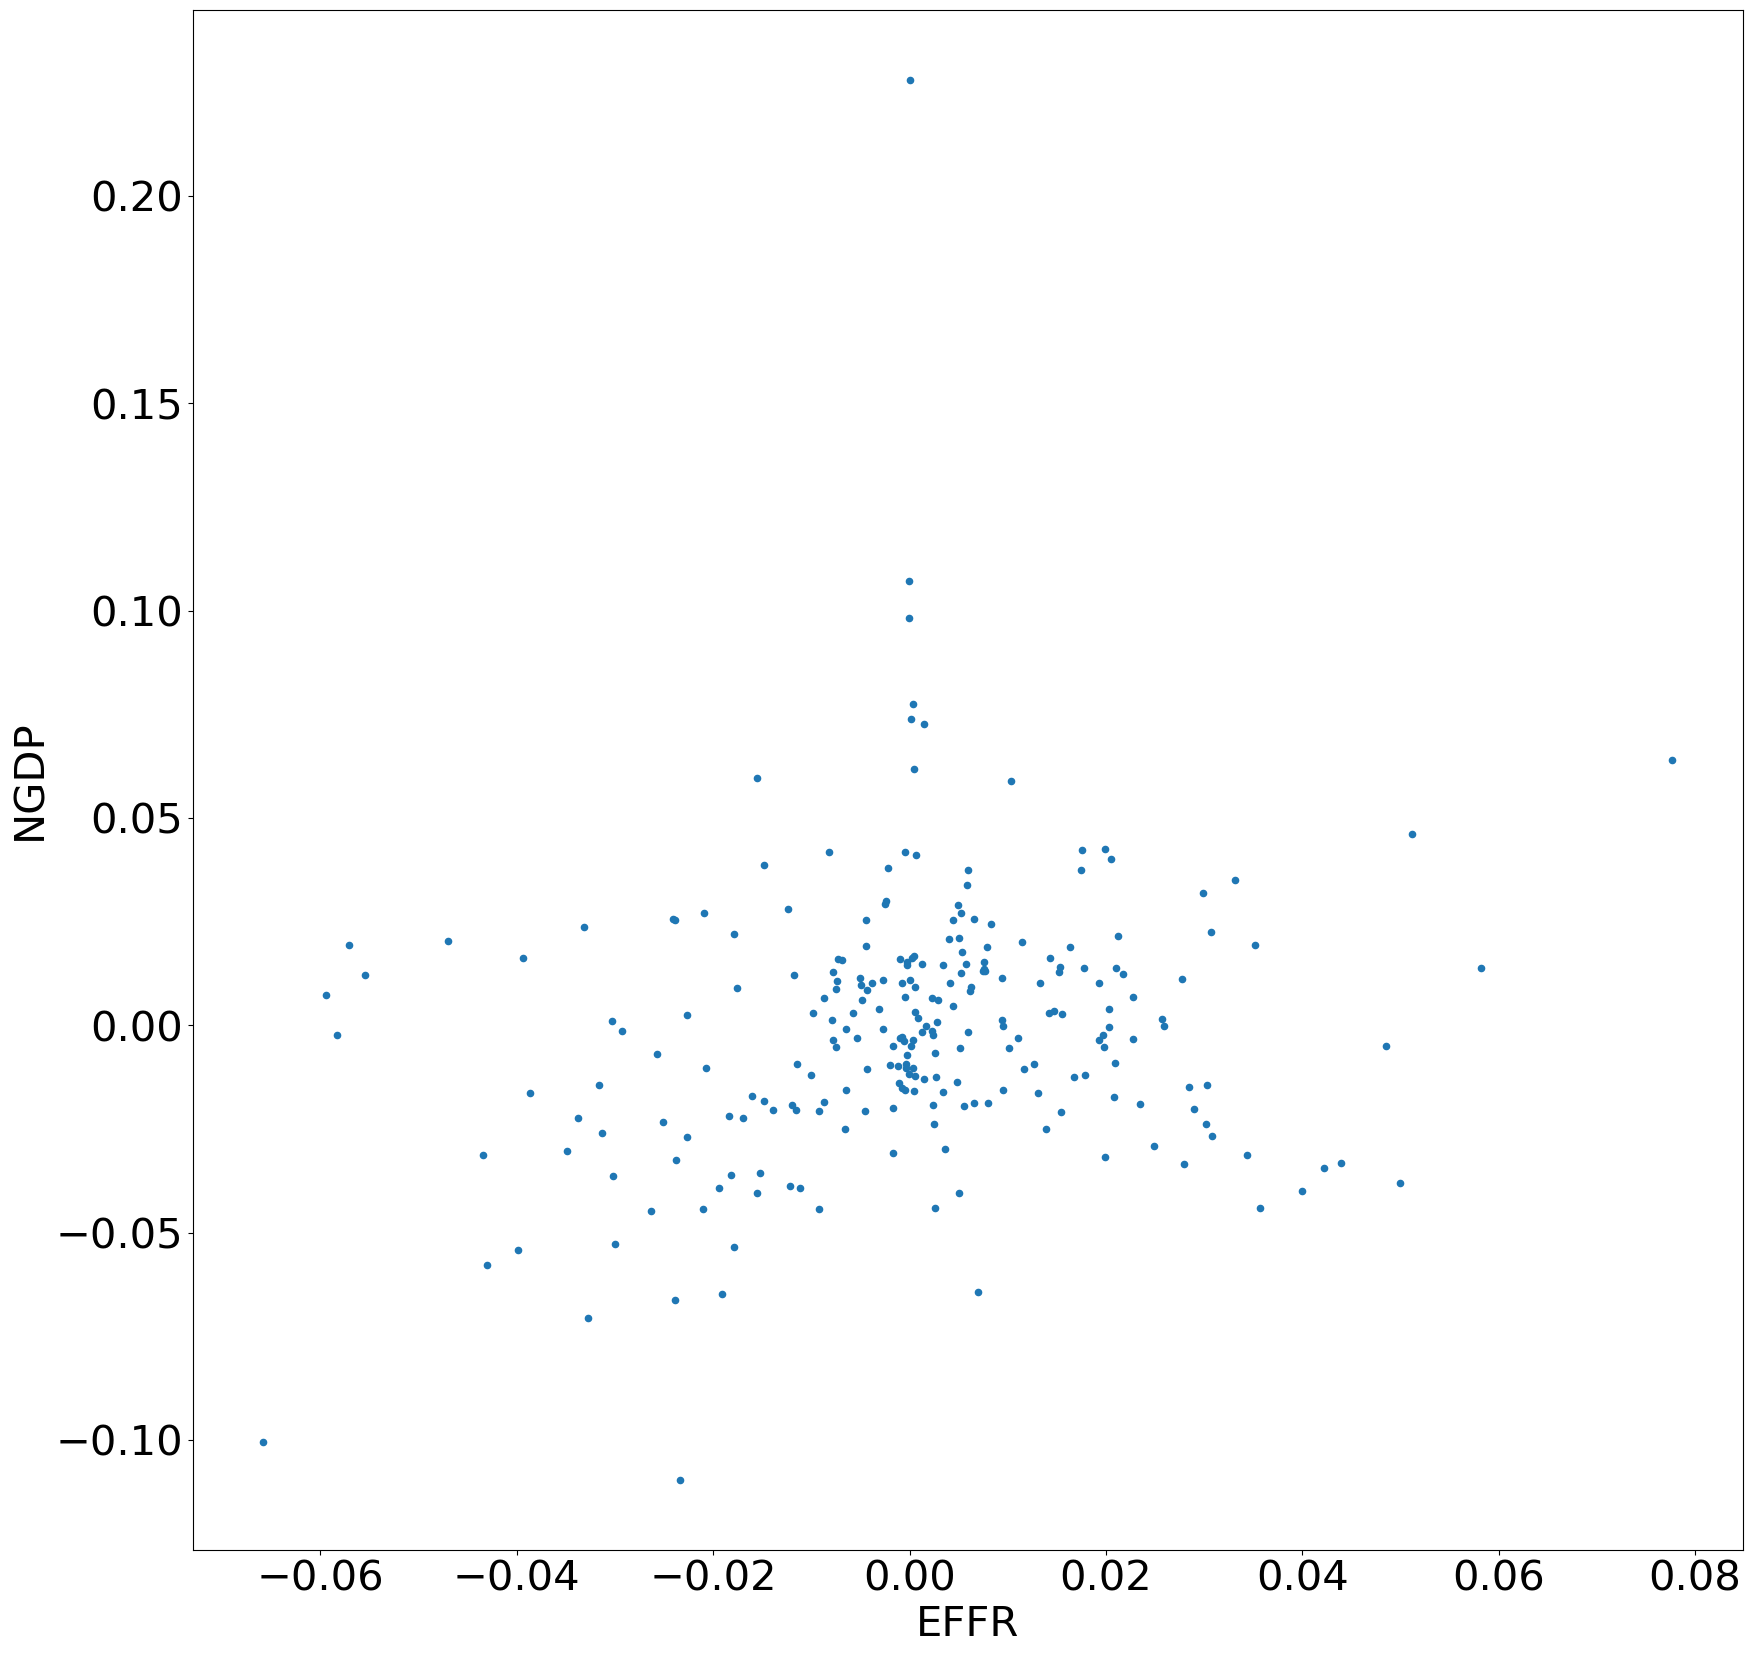

In [9]:
plt.rcParams.update({"font.size":30})
fig, ax = plt.subplots(figsize = (20,20))
rate_data.diff(freq).plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
rate_data.diff(freq).corr()

In [10]:
def build_smooth_multiple_regression_estimator(reg, orig_df):
    def find_between_from_list(lst, start, end):
        for i in range(len(lst)):
            s = lst[i]
            if start in s and end in s:
                lst[i] = (s.split(start))[1].split(end)[0]
        return lst    
    results = reg.fit()
    df = reg.data.frame
    orig_names =  find_between_from_list(list(reg.data.orig_endog.keys()) + list(reg.data.orig_exog.keys()), "(", ")")
    y_var, X_vars = orig_names[0], orig_names[1:]
    X_vars = [x for x in X_vars if x != "Intercept" and x in df.keys()]
    for x_name in X_vars:
        x_min, x_max = df[x_name].describe()[["min","max"]]
        X = pd.DataFrame({x_name: np.linspace(x_min, x_max, num = 1000)})
        keys = [x for x in X_vars if x != x_name]
        X[keys] = df[keys].mean()
        lpr_PICI = results.get_prediction(X).summary_frame(alpha = 0.05)
        lpr_PICI.index = X[x_name]
        lpr_CI = lpr_PICI[["mean", "mean_ci_lower", "mean_ci_upper"]]
        fig, ax = plt.subplots(figsize = (20,10))
        for key in lpr_CI:
            ls, alpha = ("--", .5) if "ci" in key else ("-", 1)
            lpr_CI[[key]].plot(ls = ls, 
                               linewidth = 3, 
                               alpha = alpha, color = "C0", ax = ax)
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_var)
        scatter_df = df.copy()
        orig_yname =  list(reg.data.orig_endog.keys())[0]
        orig_y = reg.data.orig_endog[orig_yname]
        scatter_df[y_var] = orig_y
        scatter_df.groupby(x_name).mean()[y_var].reset_index().plot.scatter(x = x_name, y = y_var, 
                                                                                ax = ax, color = "k", alpha = .75)

In [11]:
annual_rate

,B,NGDP,C,A
DATE,,,,
1959-03-31,NaN,NaN,NaN,NaN
1959-06-30,NaN,NaN,NaN,NaN
1959-09-30,NaN,NaN,NaN,NaN
1959-12-31,NaN,NaN,NaN,NaN
1960-03-31,-0.133333,6.332765,1.399904,NaN
...,...,...,...,...
2022-12-31,-15.534493,7.113487,3.566016,0.154729
2023-03-31,-11.248919,7.129637,2.771237,-4.473948
2023-06-30,-1.247711,5.945517,2.634257,-5.151955


                            OLS Regression Results                            
Dep. Variable:                   NGDP   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     34.34
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           2.97e-26
Time:                        12:38:40   Log-Likelihood:                 548.73
No. Observations:                 240   AIC:                            -1085.
Df Residuals:                     234   BIC:                            -1065.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0001      0.002      0.089      0.9

,NGDP,EFFR,UST10Y,C,B,NGDPLag1
NGDP,1.000000,0.157541,0.147654,0.060553,-0.370545,-0.543944
EFFR,0.157541,1.000000,0.553915,-0.079582,-0.001666,0.230526
UST10Y,0.147654,0.553915,1.000000,0.050130,-0.002690,0.082532
C,0.060553,-0.079582,0.050130,1.000000,0.578627,-0.066013
B,-0.370545,-0.001666,-0.002690,0.578627,1.000000,-0.159438
NGDPLag1,-0.543944,0.230526,0.082532,-0.066013,-0.159438,1.000000


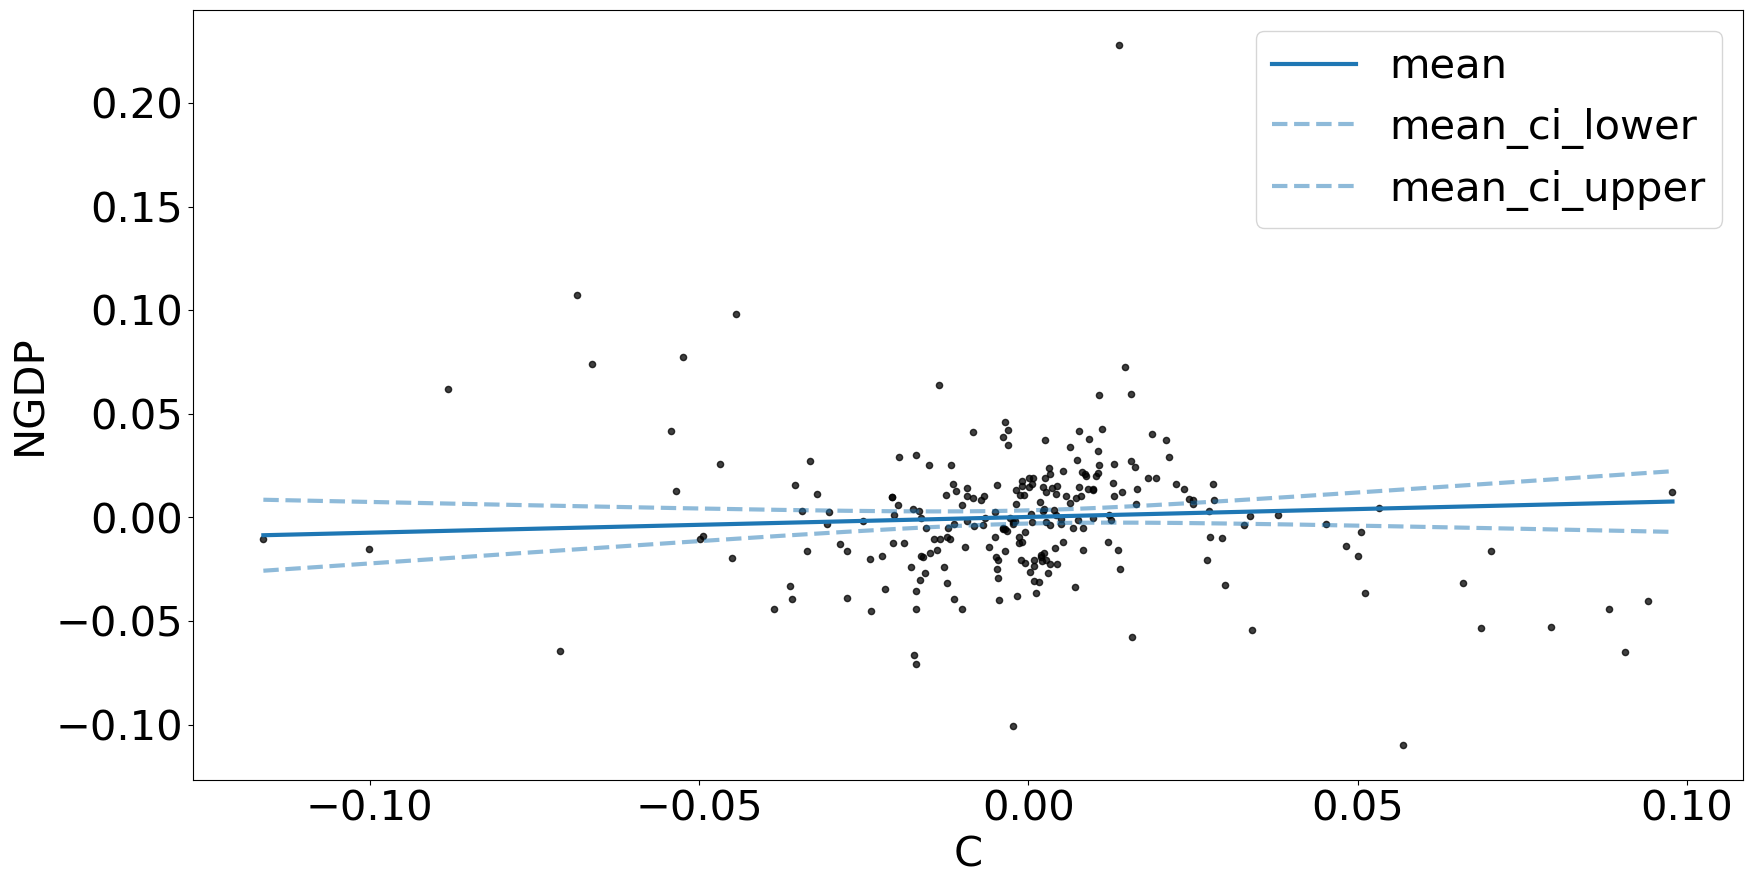

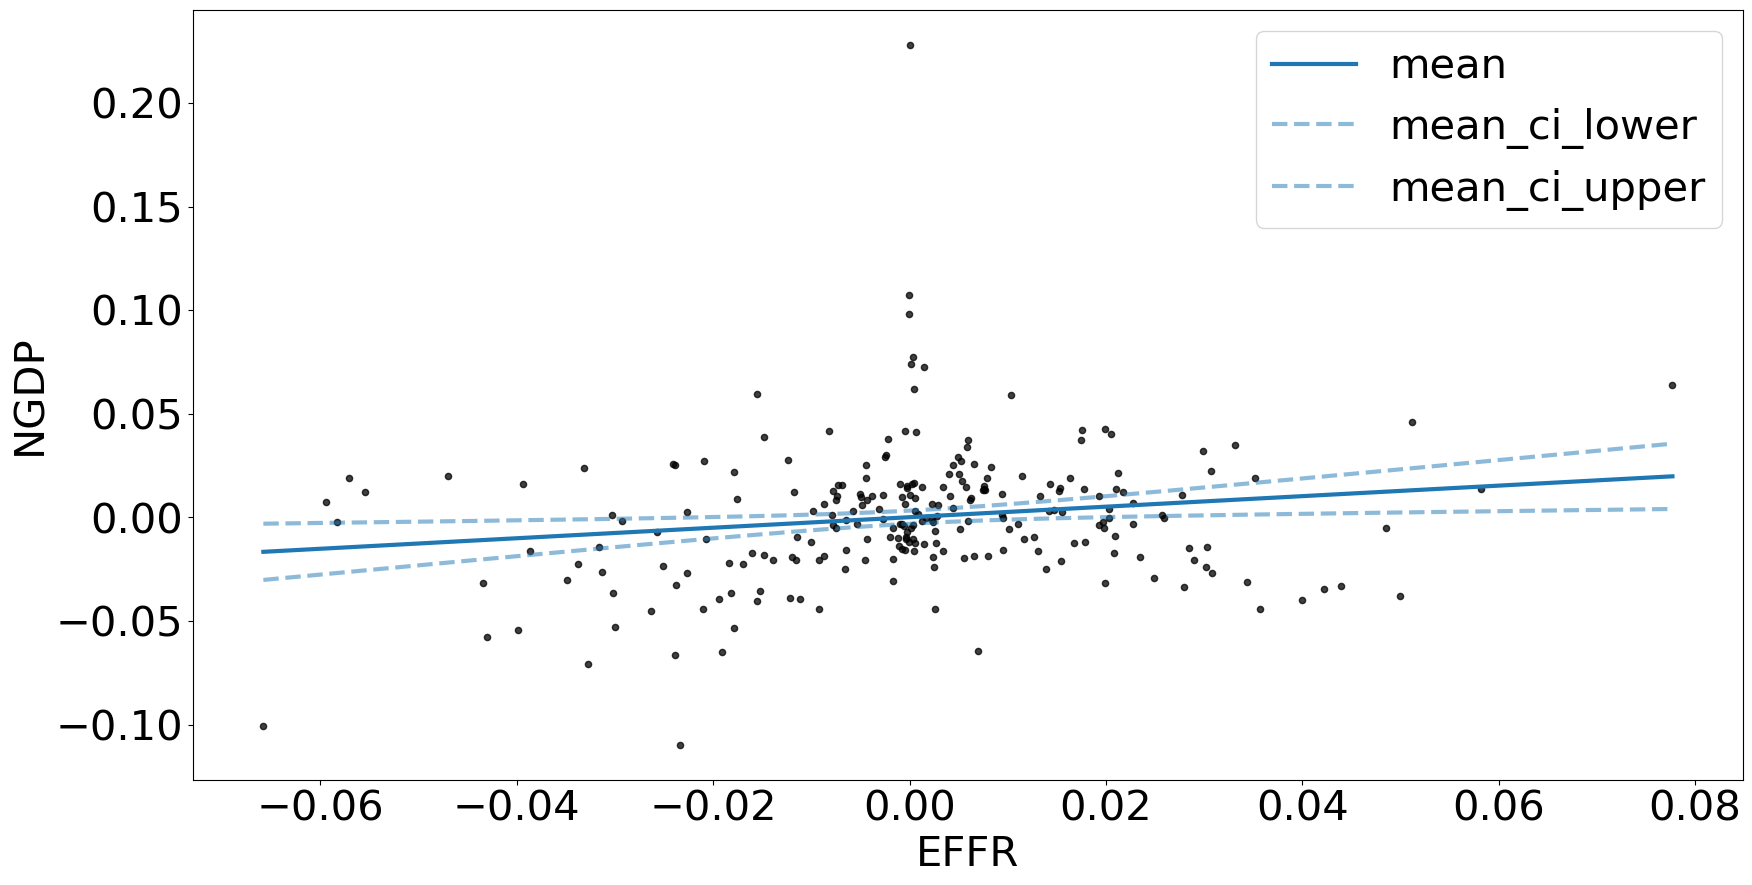

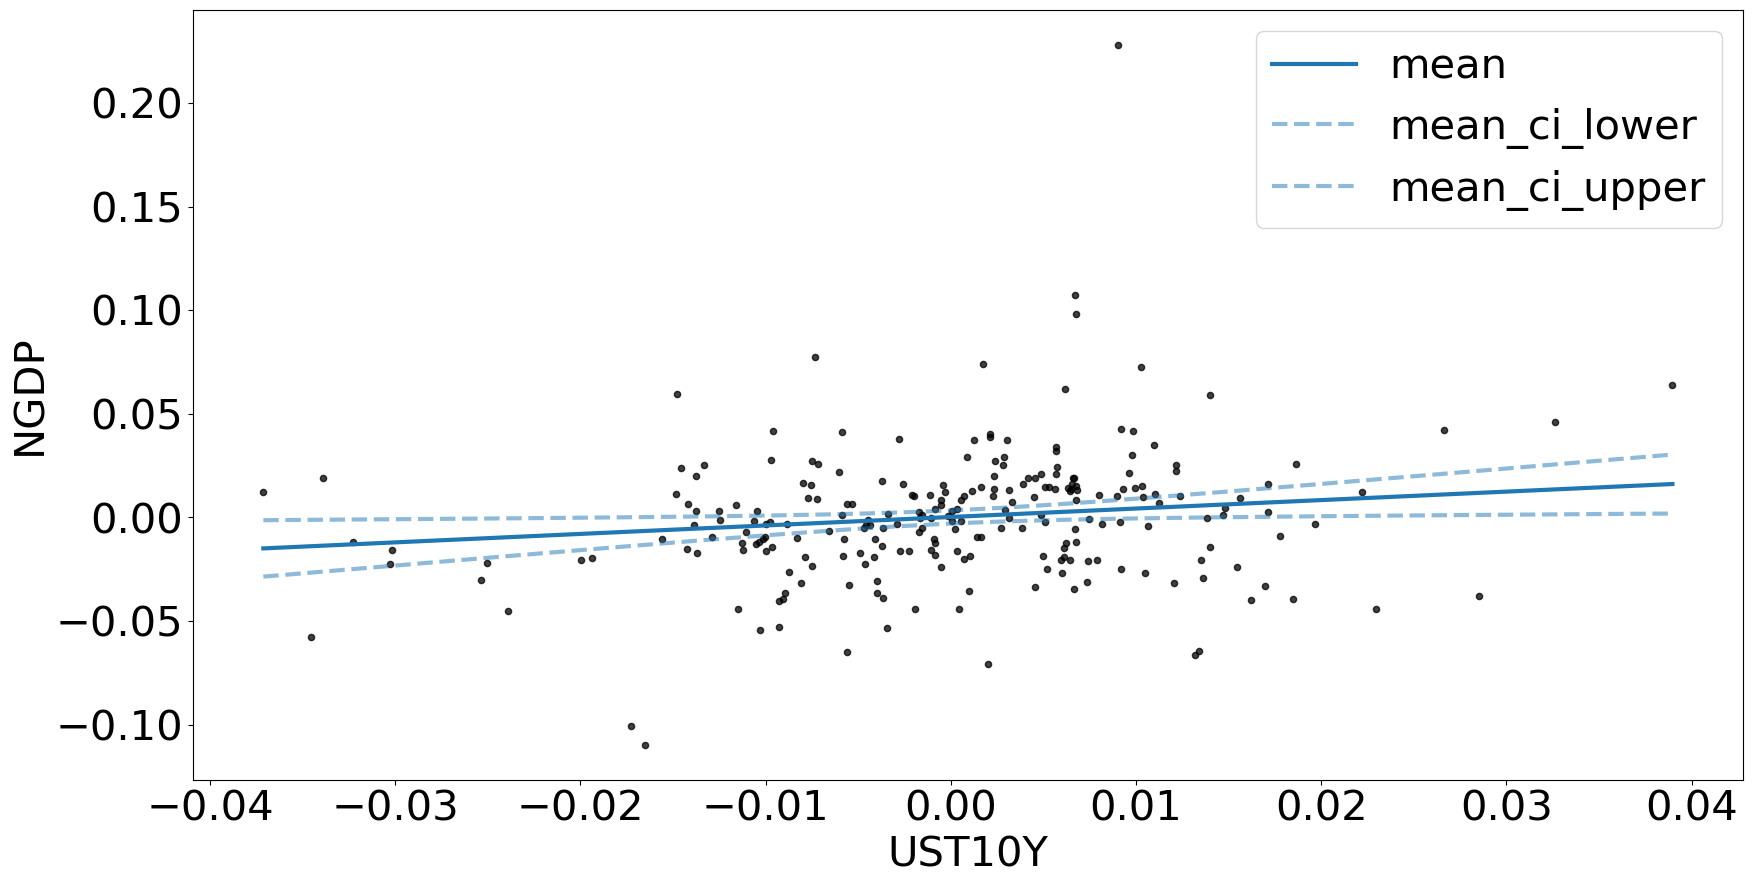

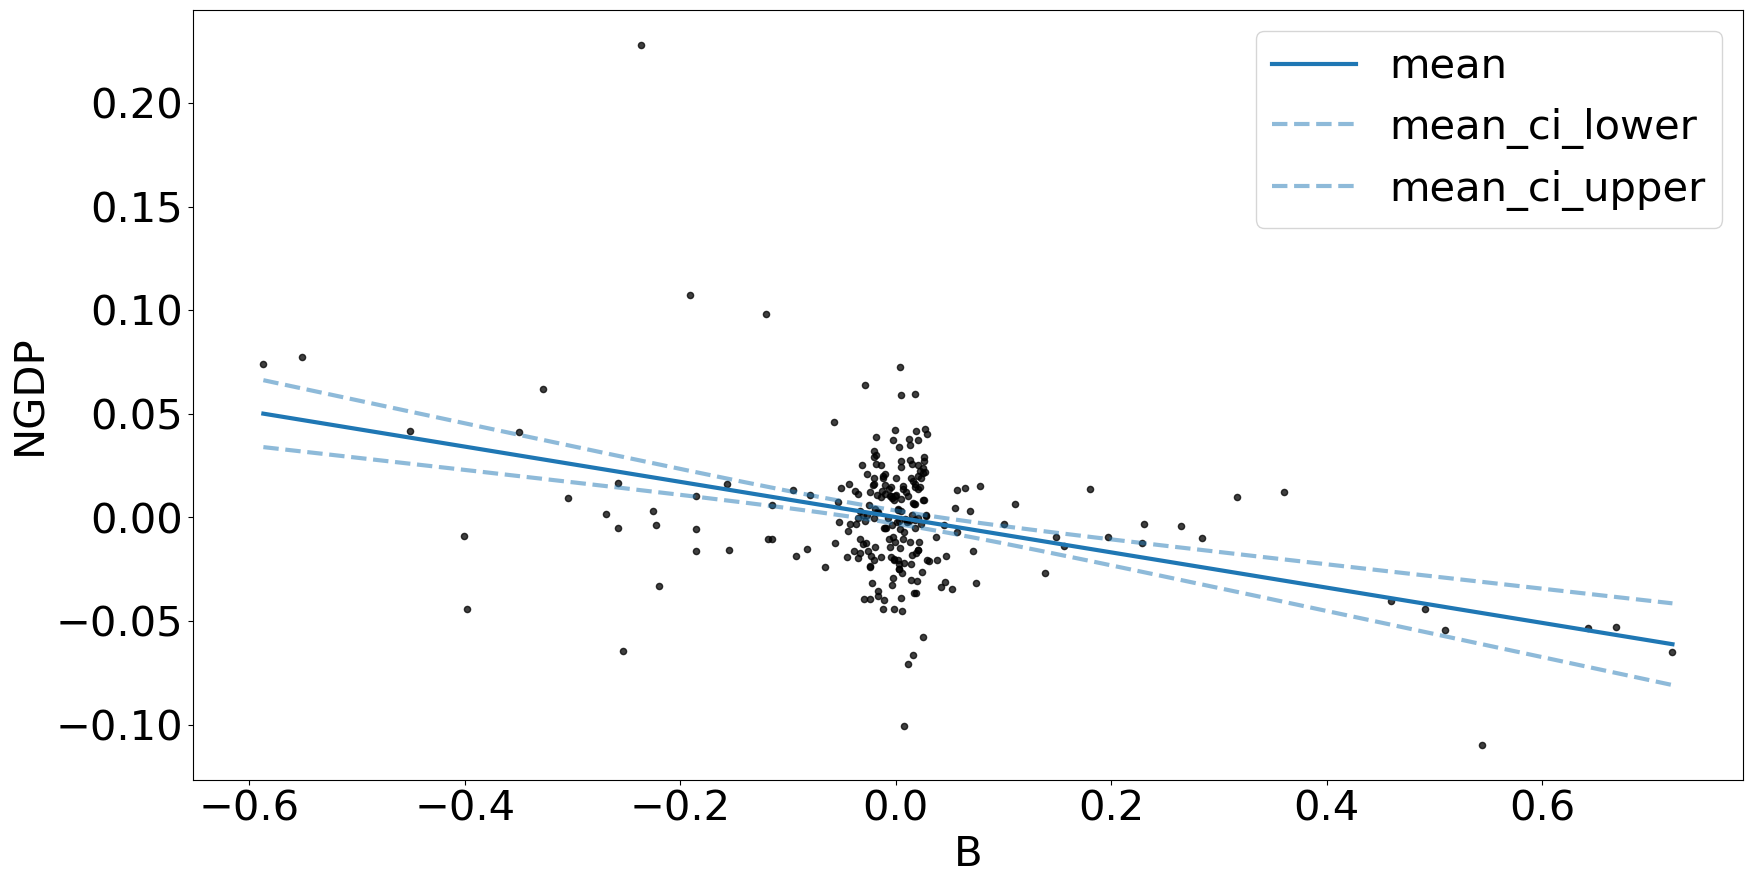

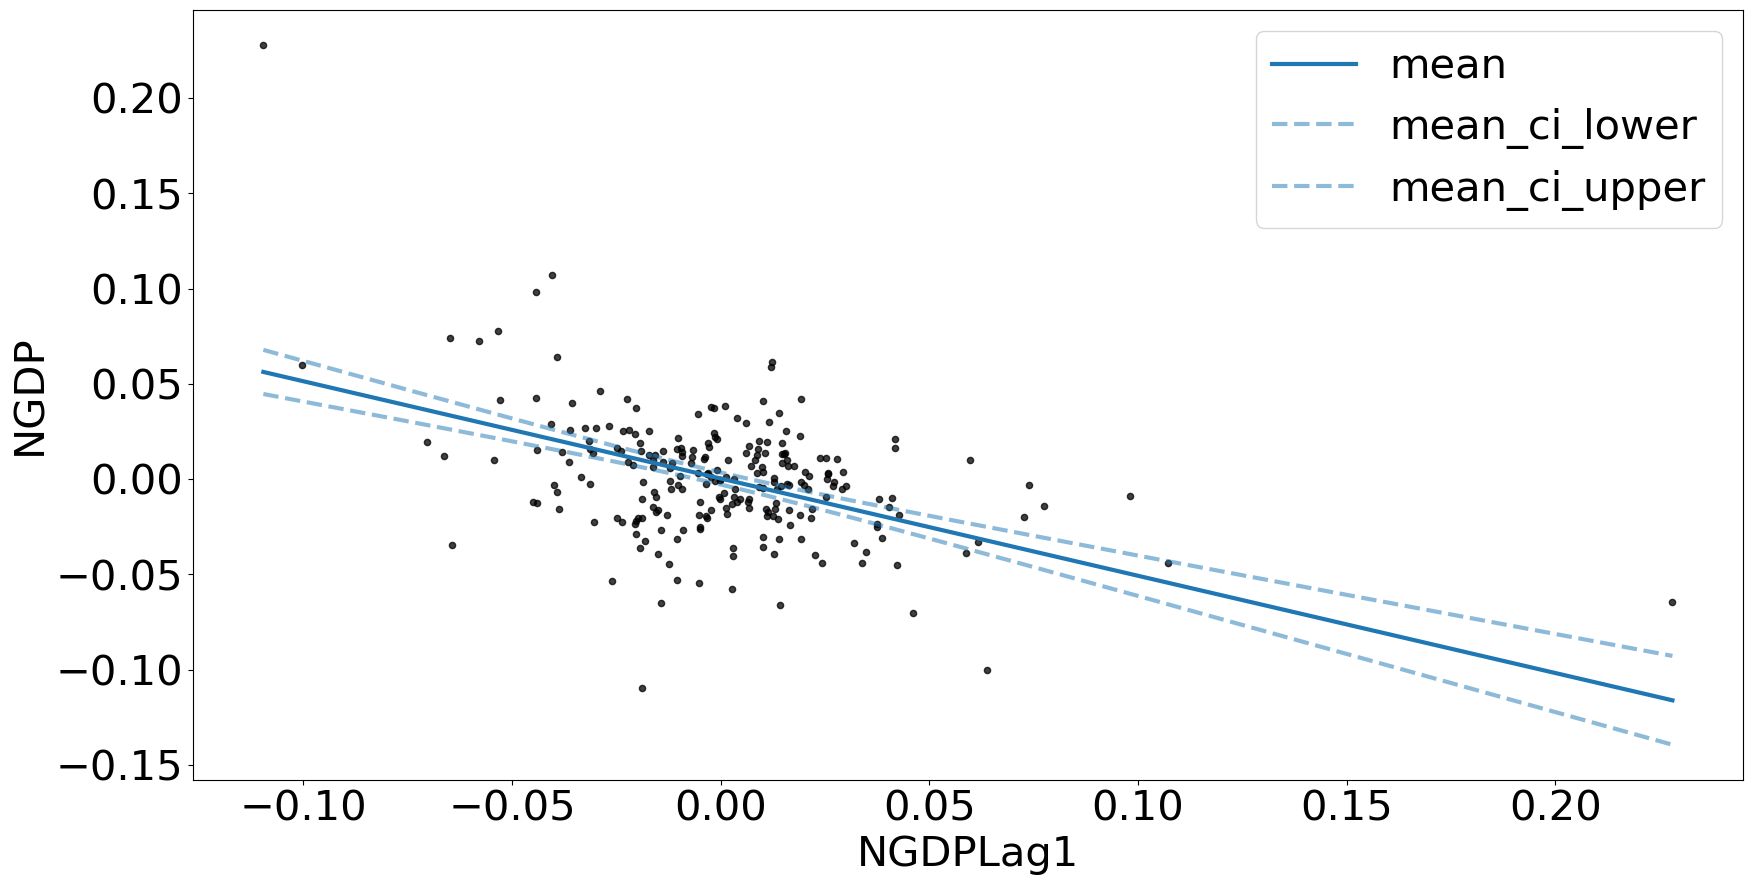

In [12]:
# fig, ax = plt.subplots(figsize = (20,20))
lags = 1
plot_vars = ["NGDP",  "EFFR", "UST10Y", "C", "B"]
# annual_rate["FRAssets"].fillna(0, inplace = True)
plot_df = rate_data.diff(freq)[plot_vars]#.loc[:"2003"]
formula = 'NGDP ~  C + EFFR + UST10Y + B'
for key in plot_df:
    for i in range(1, lags + 1):
        plot_df[key + "Lag" + str(i)] = plot_df[key].shift(freq * i)
        formula = formula + " + NGDPLag" + str(i) 

# plot_df.plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
# y = plot_df[[plot_vars[0]]]
# X = plot_df[plot_vars[1:]]
# X["Constant"] = 1
# reg = sm.OLS(y, X)
reg = smf.ols(
    formula=formula,
    data = plot_df)
results = reg.fit()
print(results.summary())
build_smooth_multiple_regression_estimator(reg, plot_df)
plot_df[plot_vars + ["NGDPLag" + str(i) for i in range(1, lags + 1)]].pcorr()



                            OLS Regression Results                            
Dep. Variable:                   NGDP   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     17.74
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           7.26e-14
Time:                        12:38:41   Log-Likelihood:                 390.20
No. Observations:                 160   AIC:                            -768.4
Df Residuals:                     154   BIC:                            -749.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.002     -0.287      0.7

,NGDP,EFFR,UST10Y,C,B,NGDPLag1
NGDP,1.000000,0.322804,0.091718,-0.005412,0.020452,-0.536999
EFFR,0.322804,1.000000,0.510399,-0.062494,0.000990,0.341900
UST10Y,0.091718,0.510399,1.000000,0.337226,-0.326550,0.091444
C,-0.005412,-0.062494,0.337226,1.000000,0.767568,-0.244094
B,0.020452,0.000990,-0.326550,0.767568,1.000000,0.194282
NGDPLag1,-0.536999,0.341900,0.091444,-0.244094,0.194282,1.000000


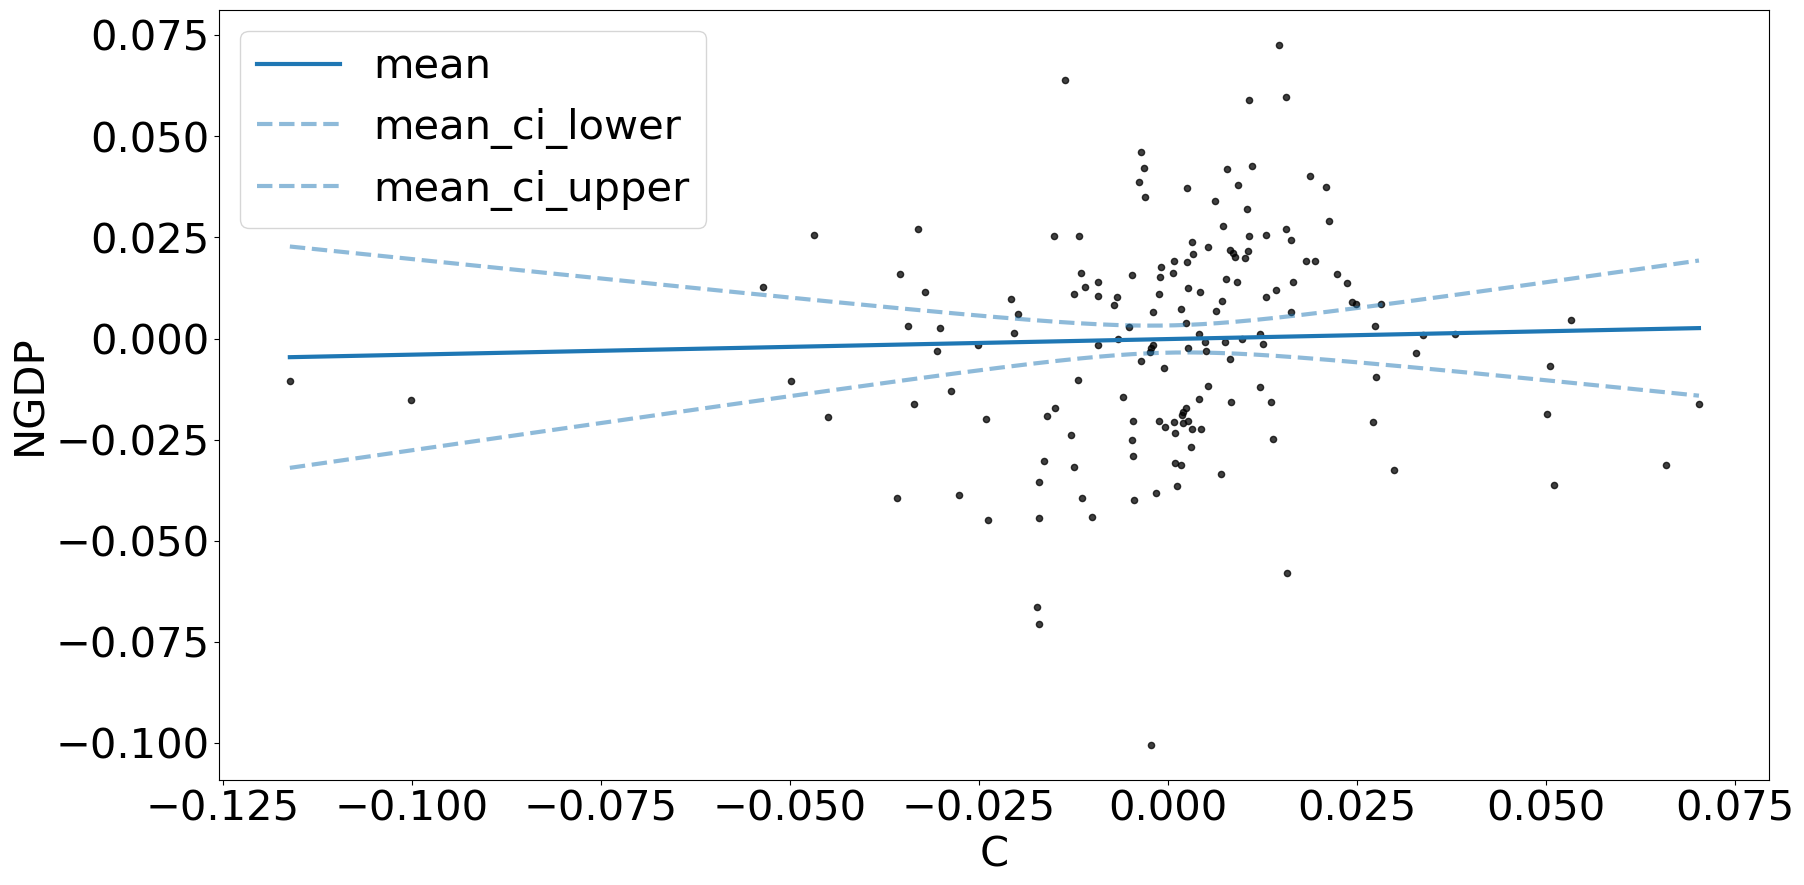

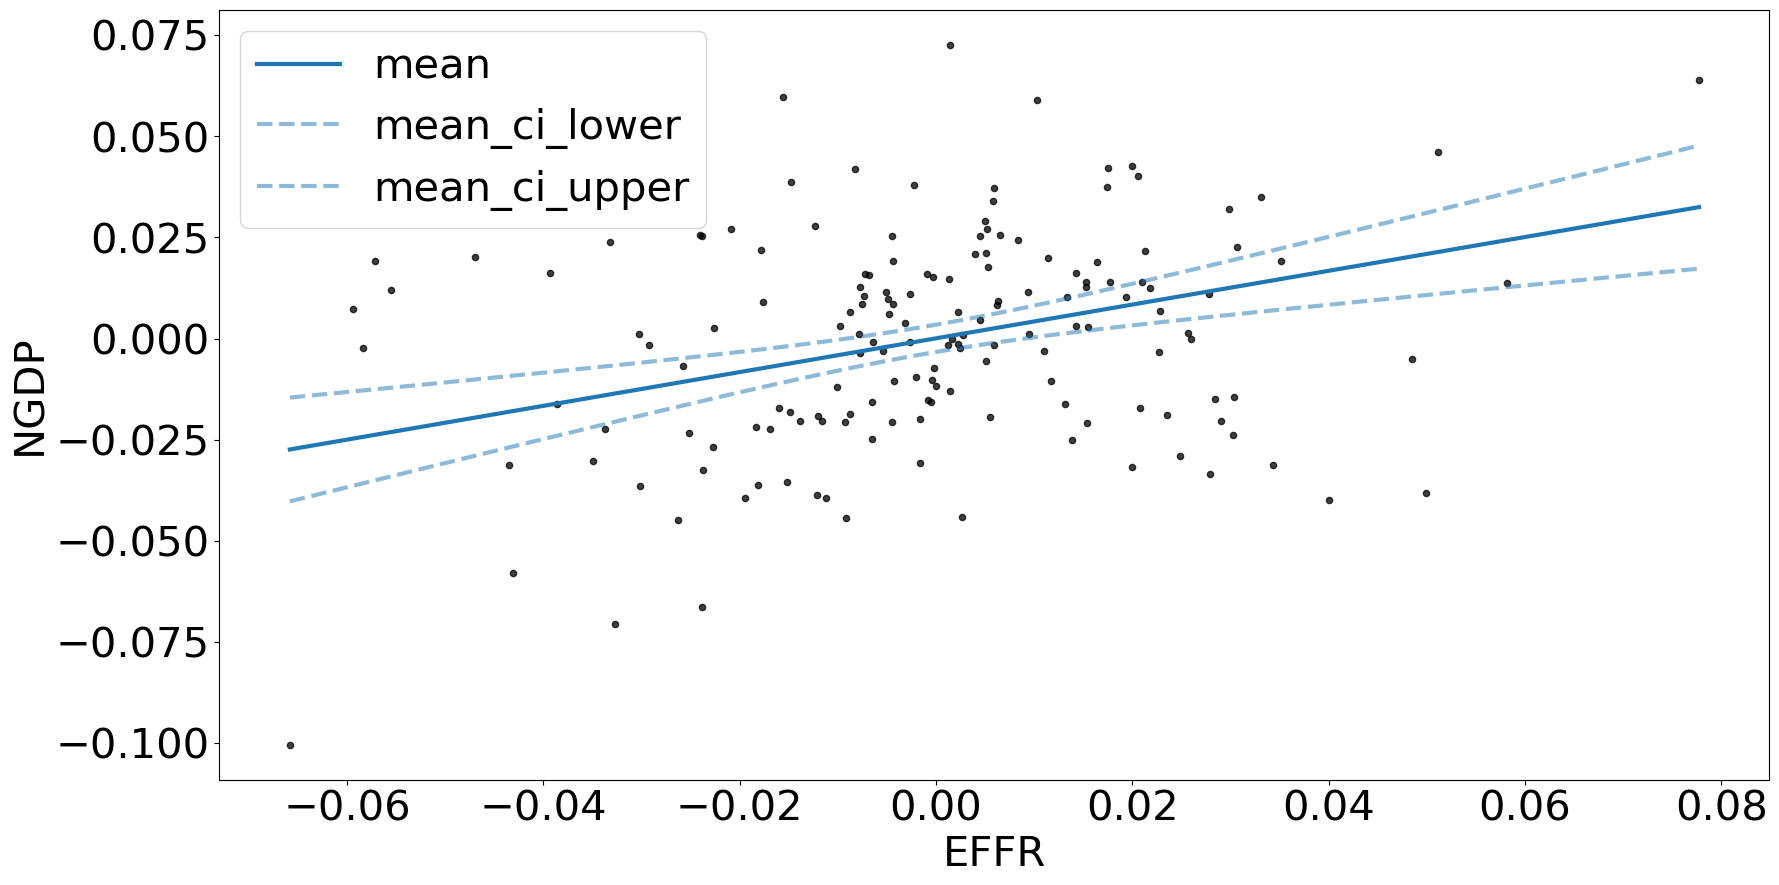

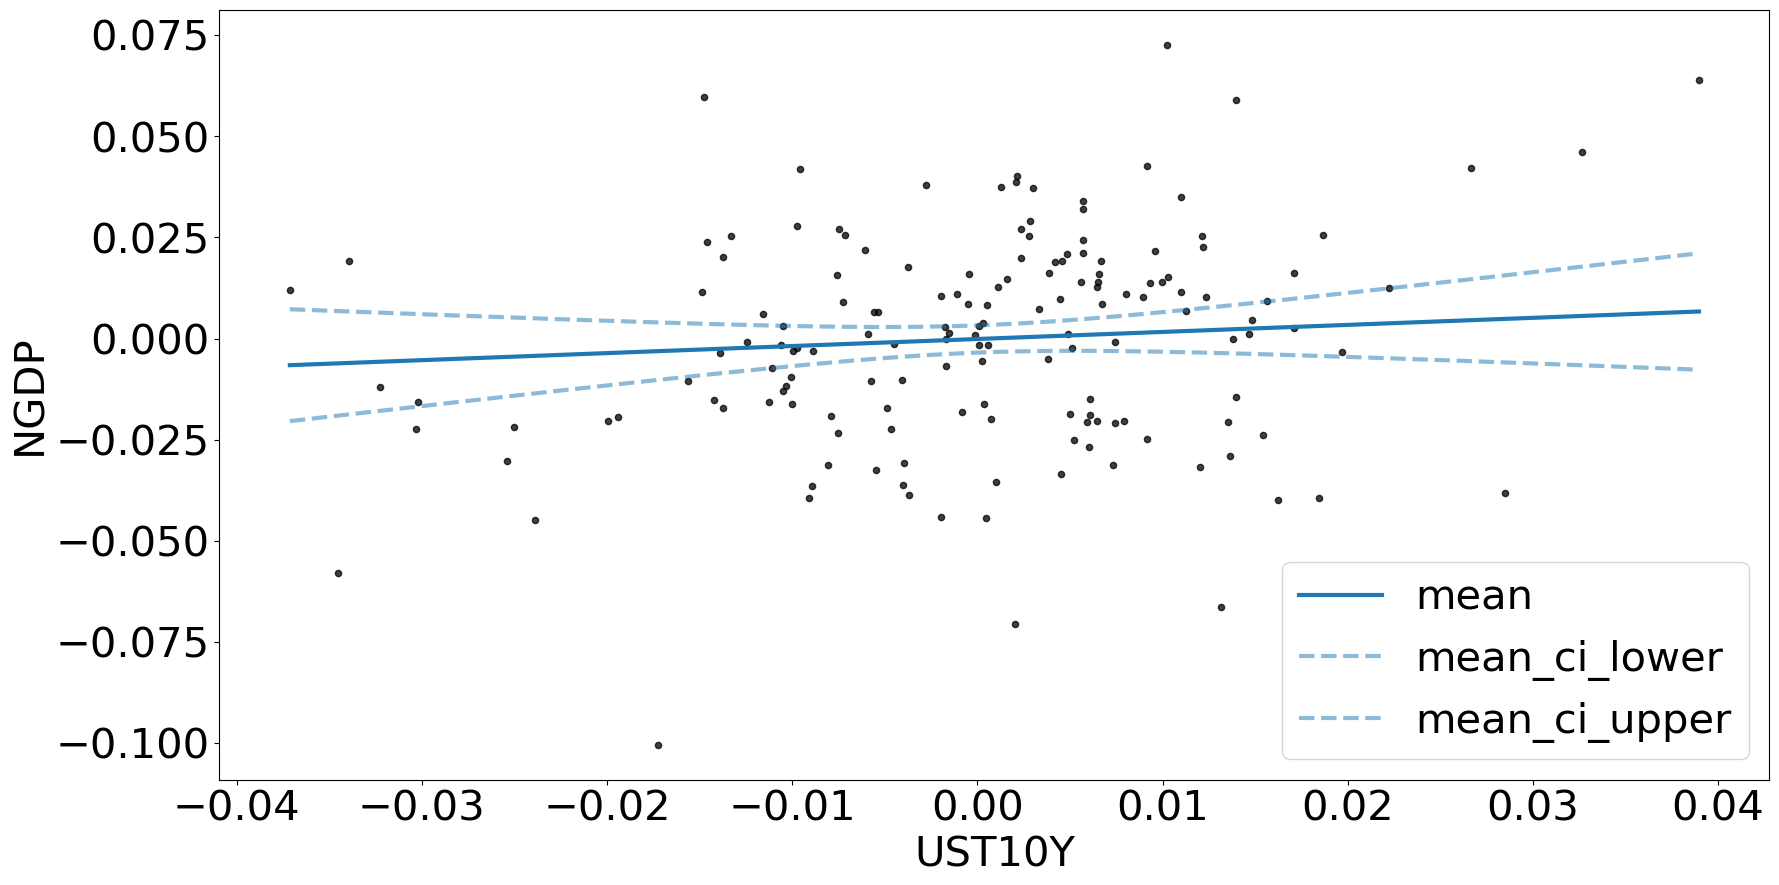

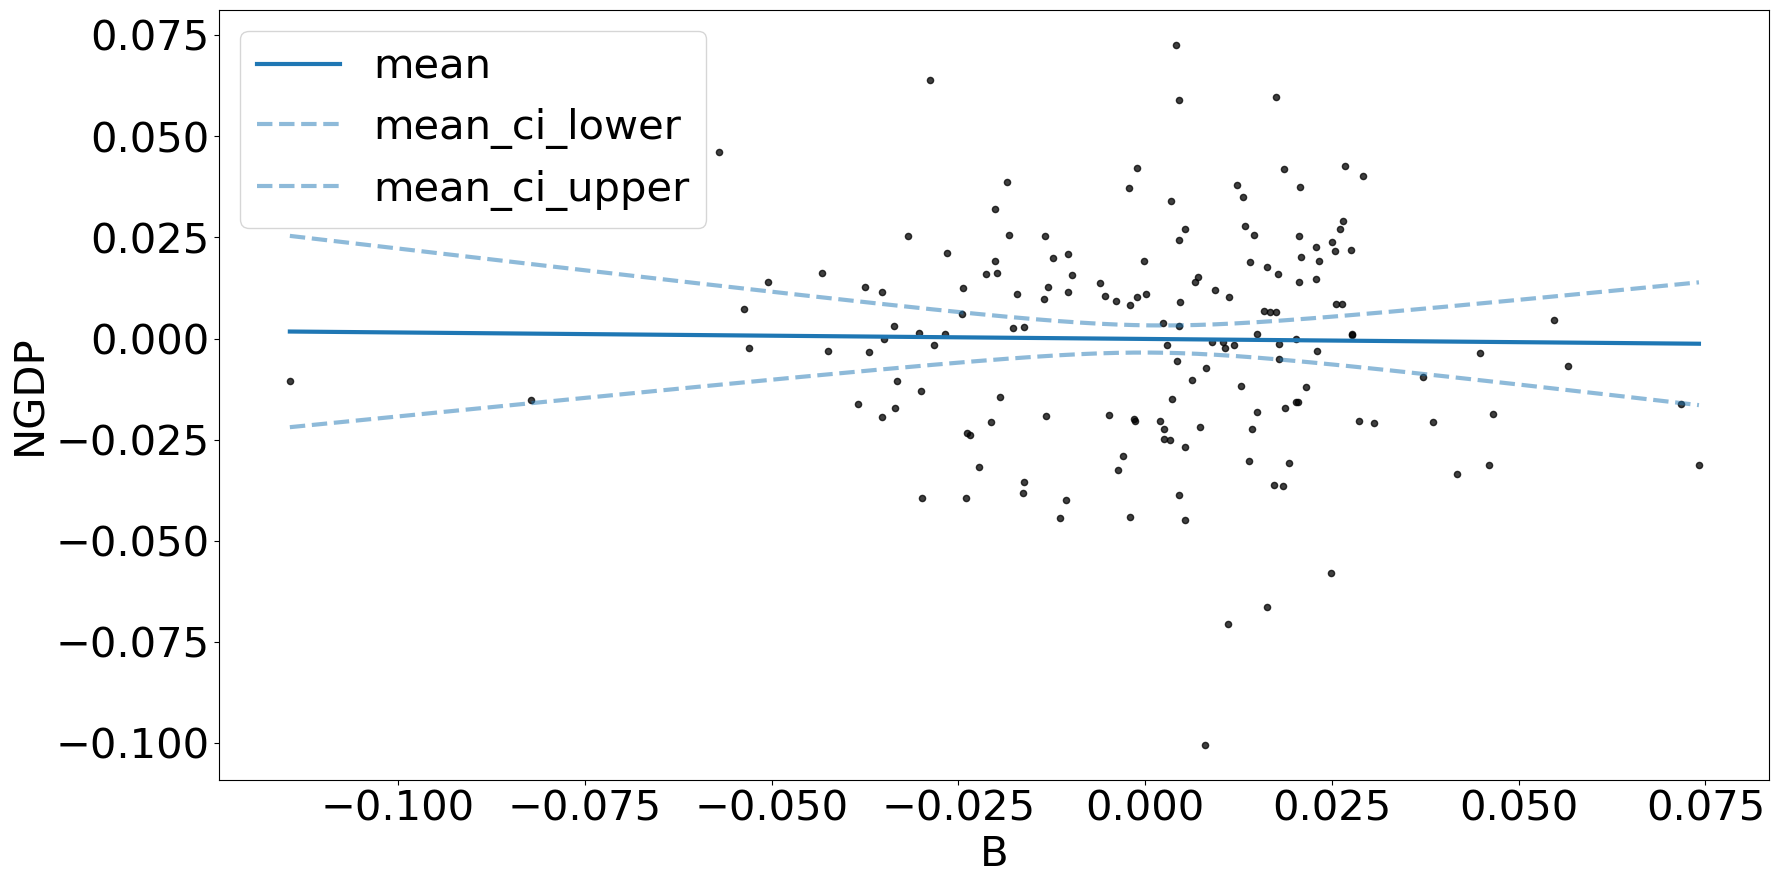

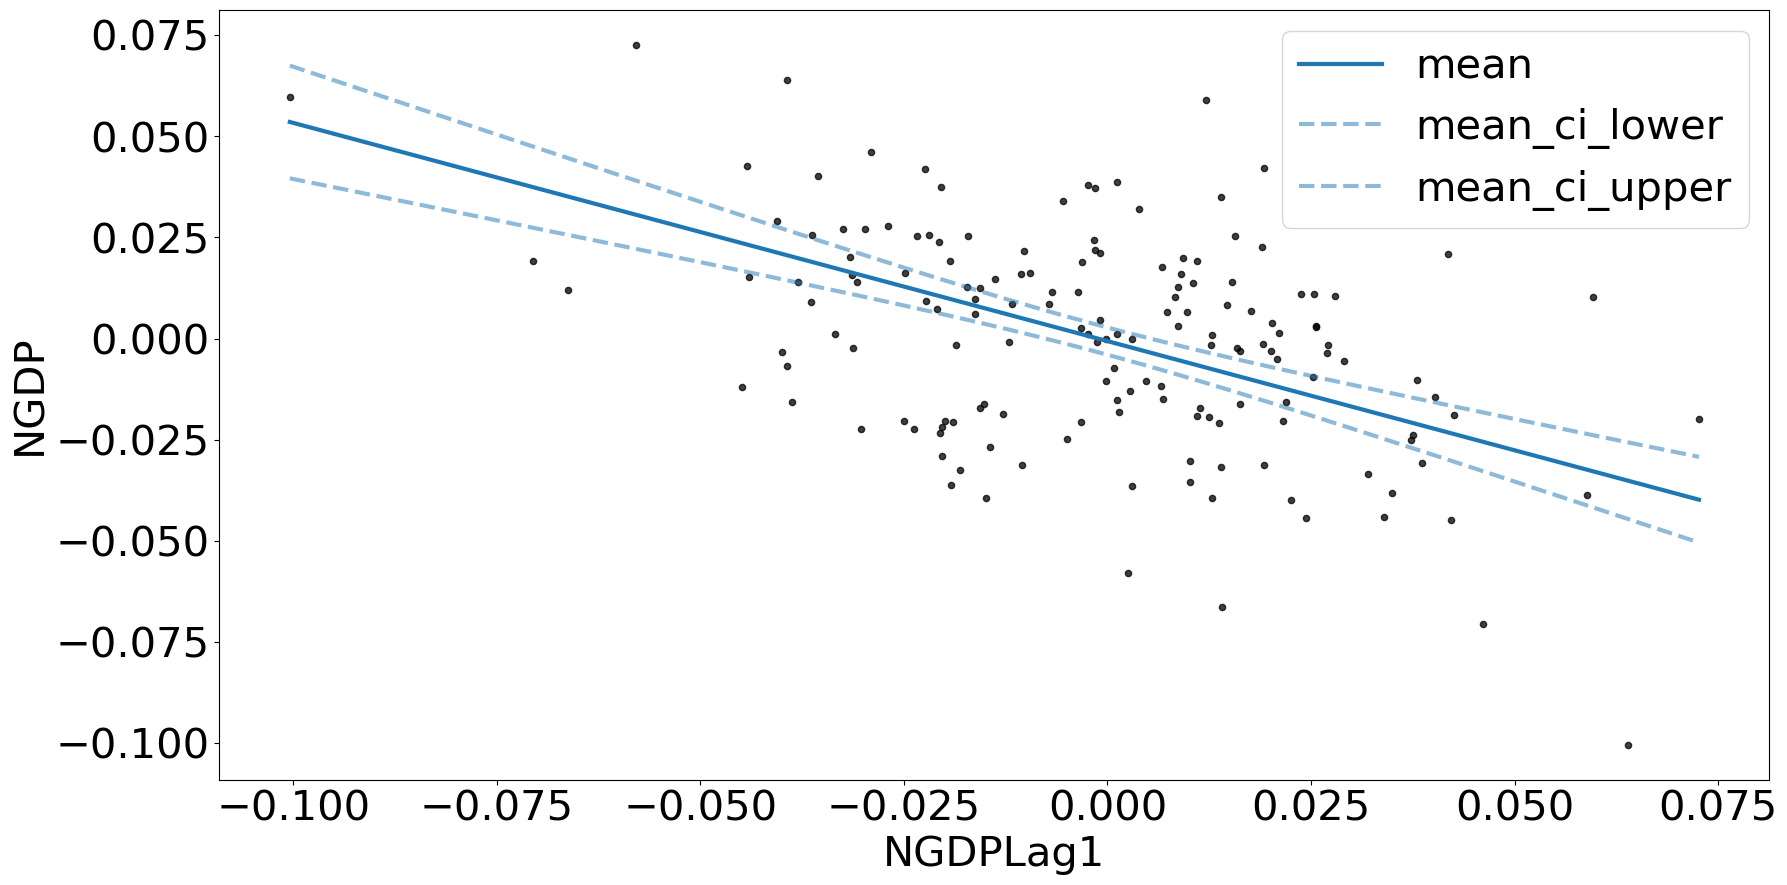

In [13]:
# fig, ax = plt.subplots(figsize = (20,20))
plot_vars = ["NGDP",  "EFFR", "UST10Y", "C", "B"]
# annual_rate["FRAssets"].fillna(0, inplace = True)
plot_df = rate_data.diff(freq)[plot_vars].loc[:"2003"]
formula = 'NGDP ~  C + EFFR + UST10Y + B'
for key in plot_df:
    for i in range(1, lags + 1):
        plot_df[key + "Lag" + str(i)] = plot_df[key].shift(freq * i)
        formula = formula + " + NGDPLag" + str(i) 
# plot_df.plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
# y = plot_df[[plot_vars[0]]]
# X = plot_df[plot_vars[1:]]
# X["Constant"] = 1
# reg = sm.OLS(y, X)
reg = smf.ols(
    formula=formula,
    data = plot_df)
results = reg.fit()
print(results.summary())
build_smooth_multiple_regression_estimator(reg, plot_df)
plot_df[plot_vars + ["NGDPLag" + str(i) for i in range(1, lags + 1)]].pcorr()


                            OLS Regression Results                            
Dep. Variable:                   NGDP   R-squared:                       0.593
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     16.00
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           2.96e-11
Time:                        12:38:43   Log-Likelihood:                 158.27
No. Observations:                  73   AIC:                            -302.5
Df Residuals:                      66   BIC:                            -286.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0016      0.003      0.461      0.6

,NGDP,EFFR,UST10Y,C,B,A,NGDPLag1
NGDP,1.000000,-0.296065,0.388326,0.177491,-0.228498,-0.178090,-0.484179
EFFR,-0.296065,1.000000,0.582817,0.098979,-0.040561,-0.242818,0.015248
UST10Y,0.388326,0.582817,1.000000,-0.325836,0.235431,0.014502,0.302747
C,0.177491,0.098979,-0.325836,1.000000,0.215124,0.287480,-0.014496
B,-0.228498,-0.040561,0.235431,0.215124,1.000000,0.735520,-0.518167
A,-0.178090,-0.242818,0.014502,0.287480,0.735520,1.000000,0.411397
NGDPLag1,-0.484179,0.015248,0.302747,-0.014496,-0.518167,0.411397,1.000000


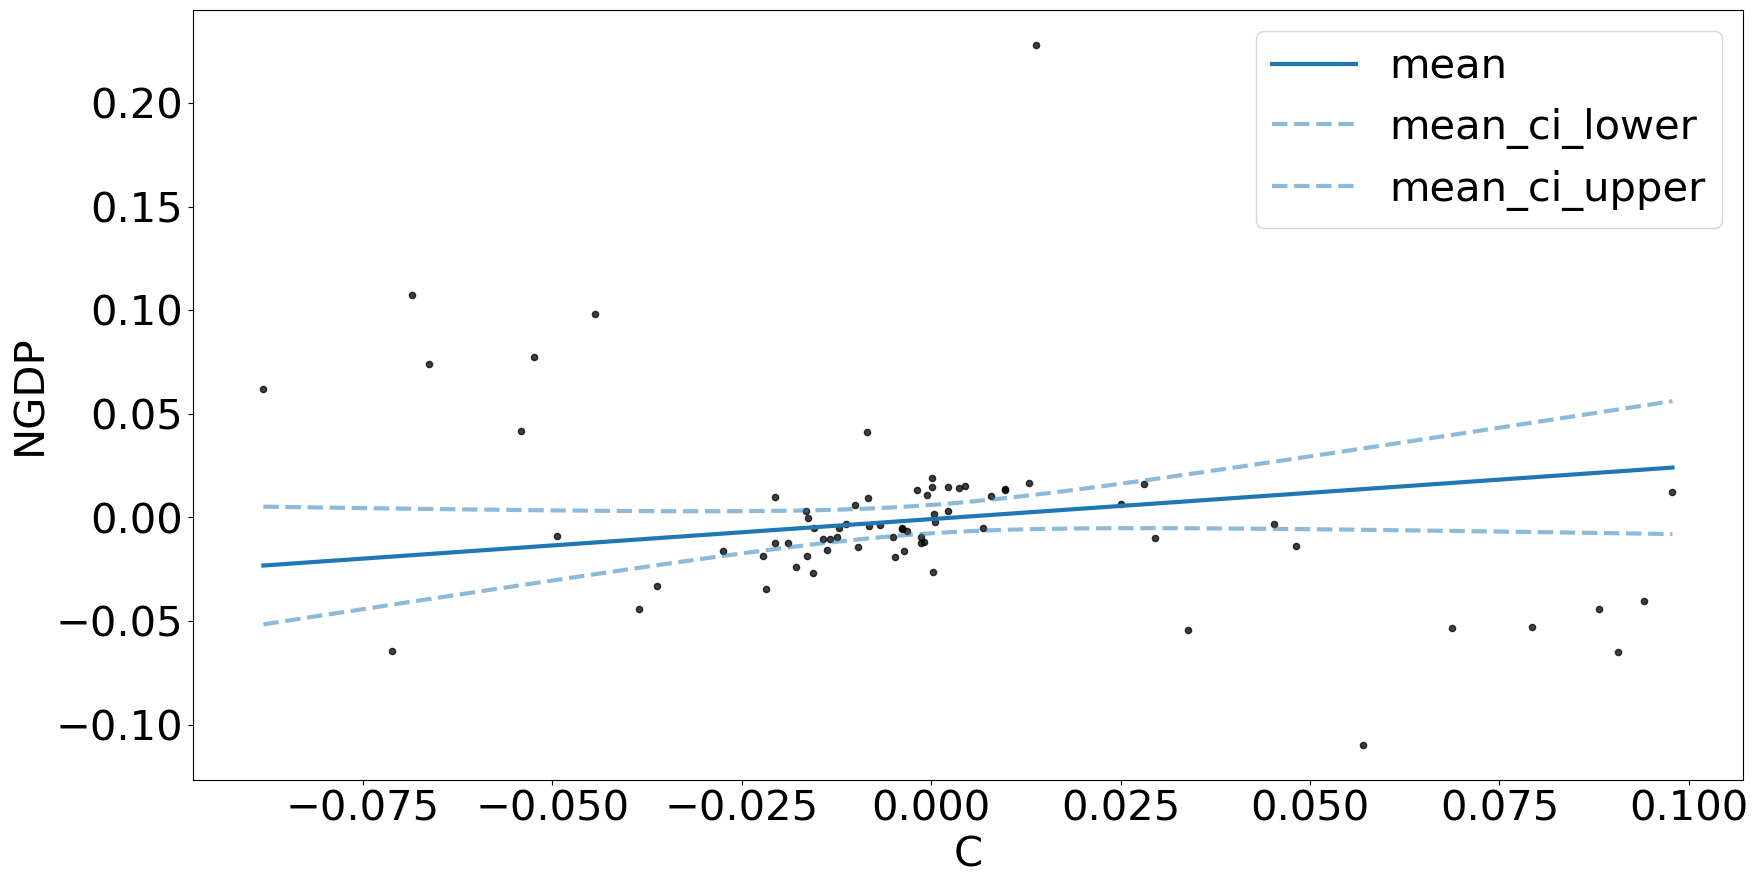

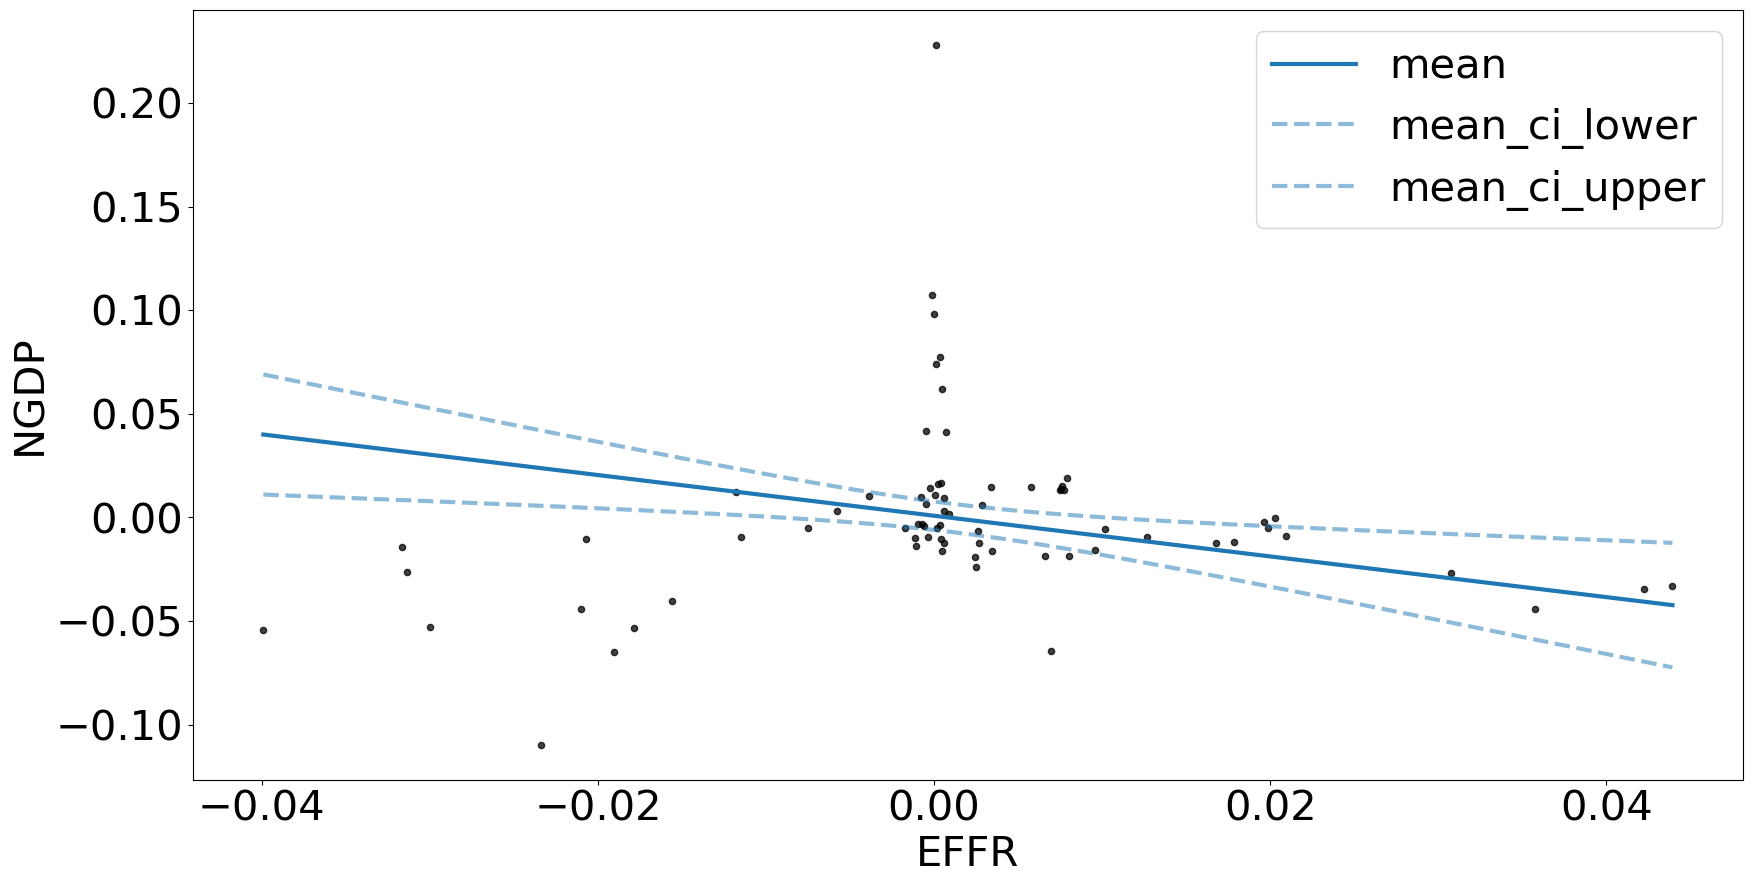

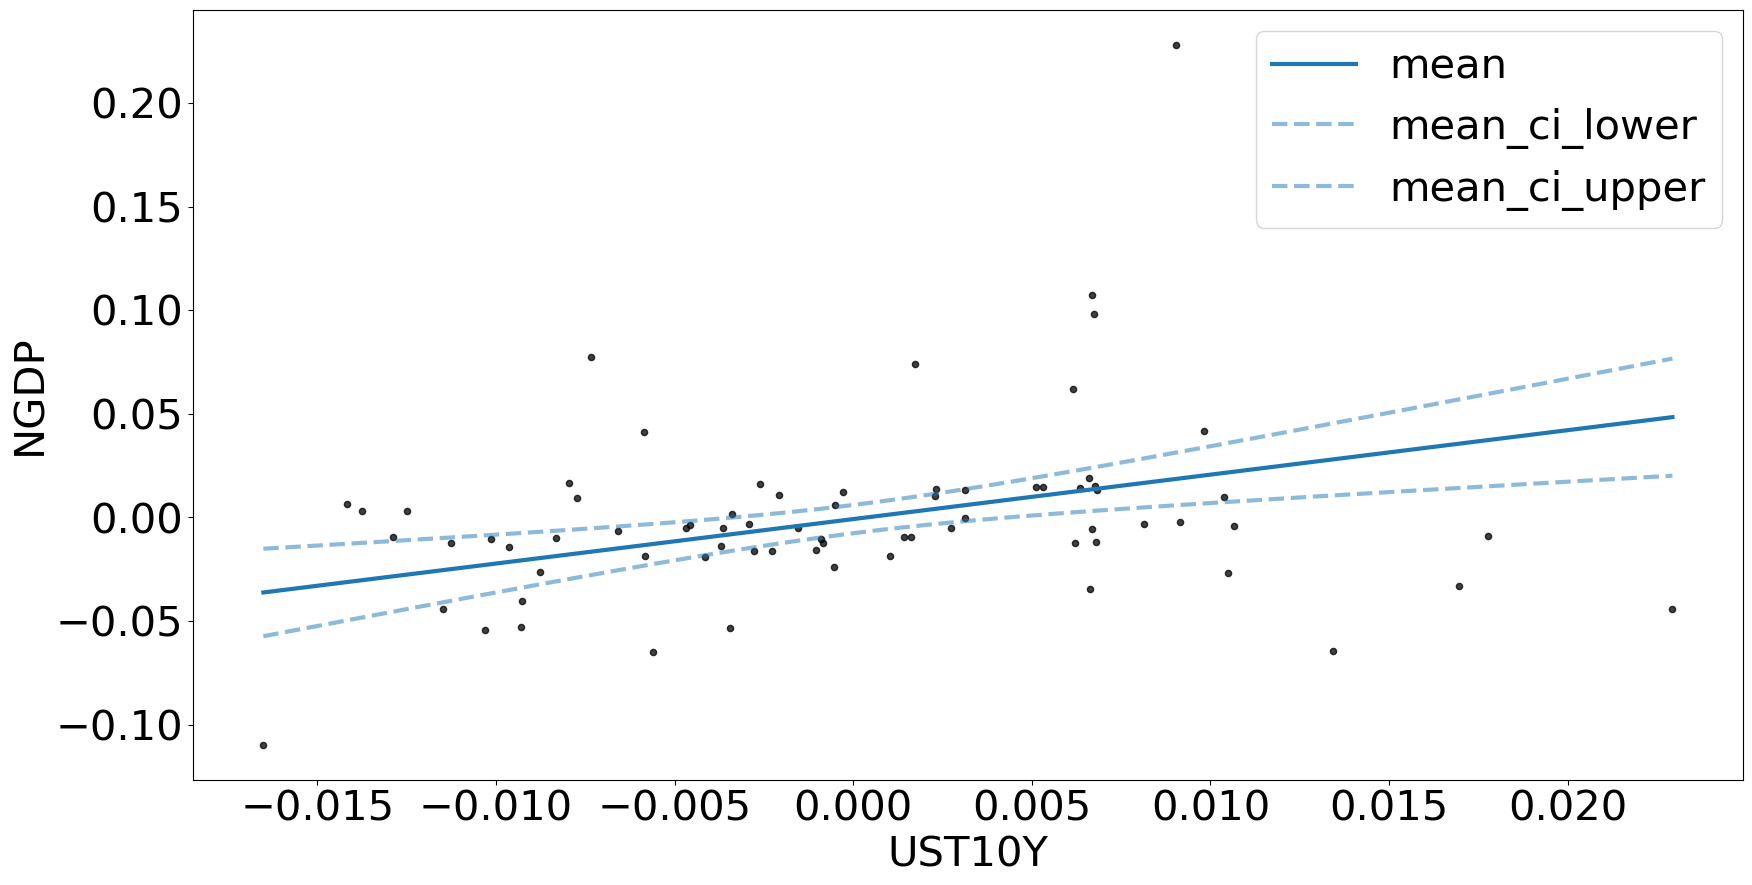

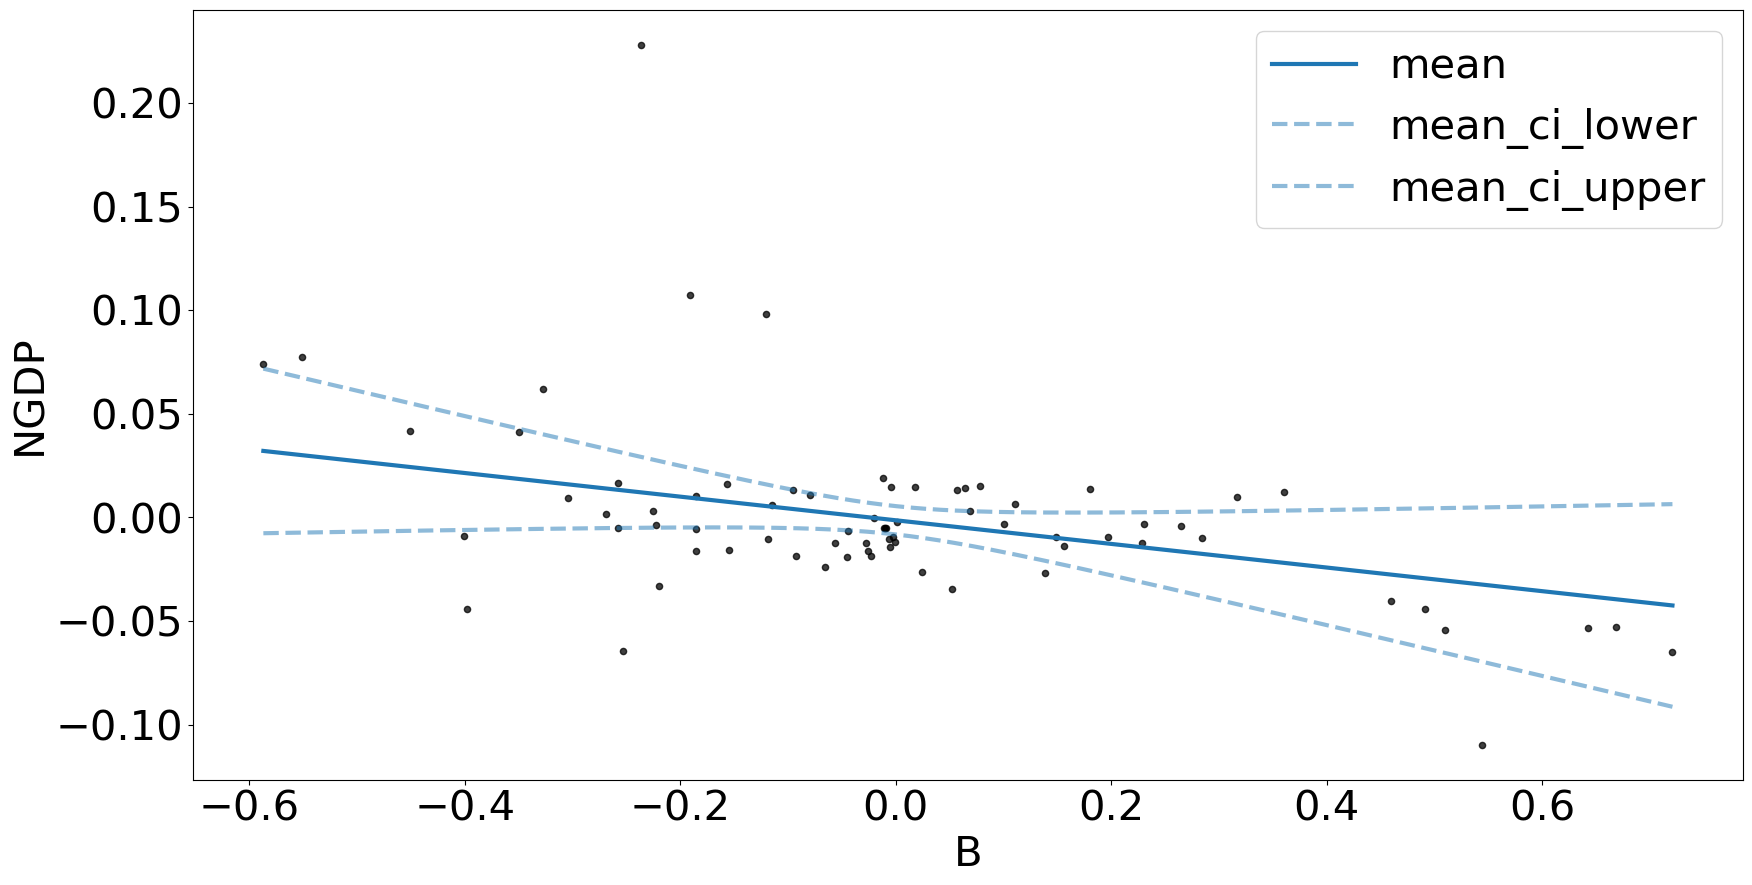

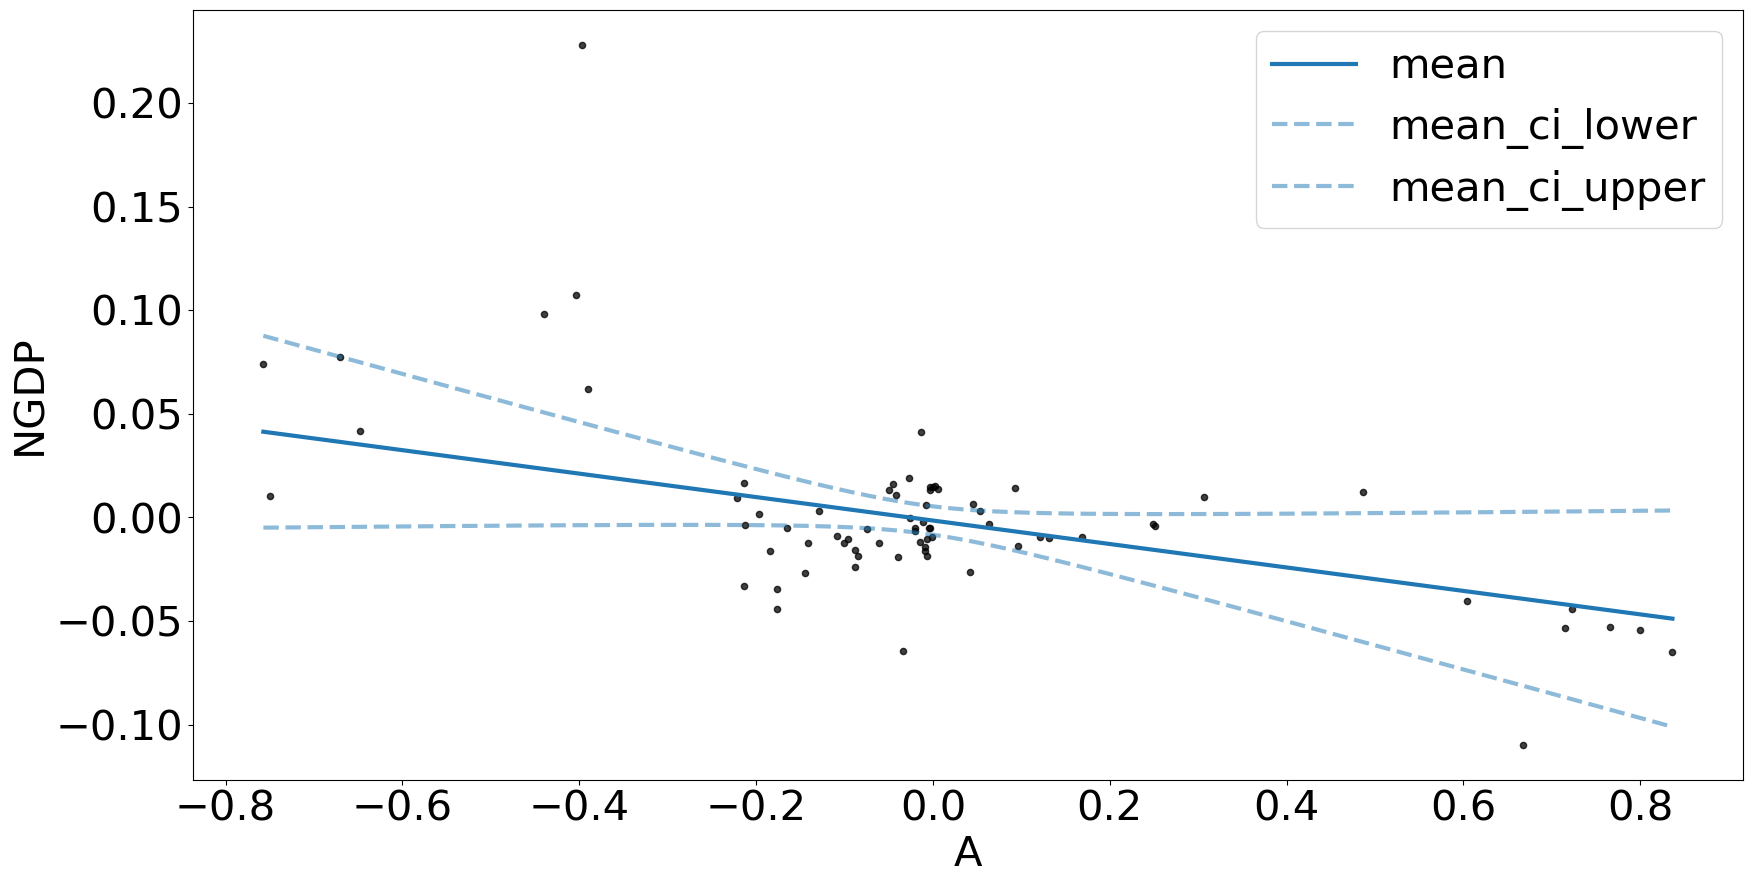

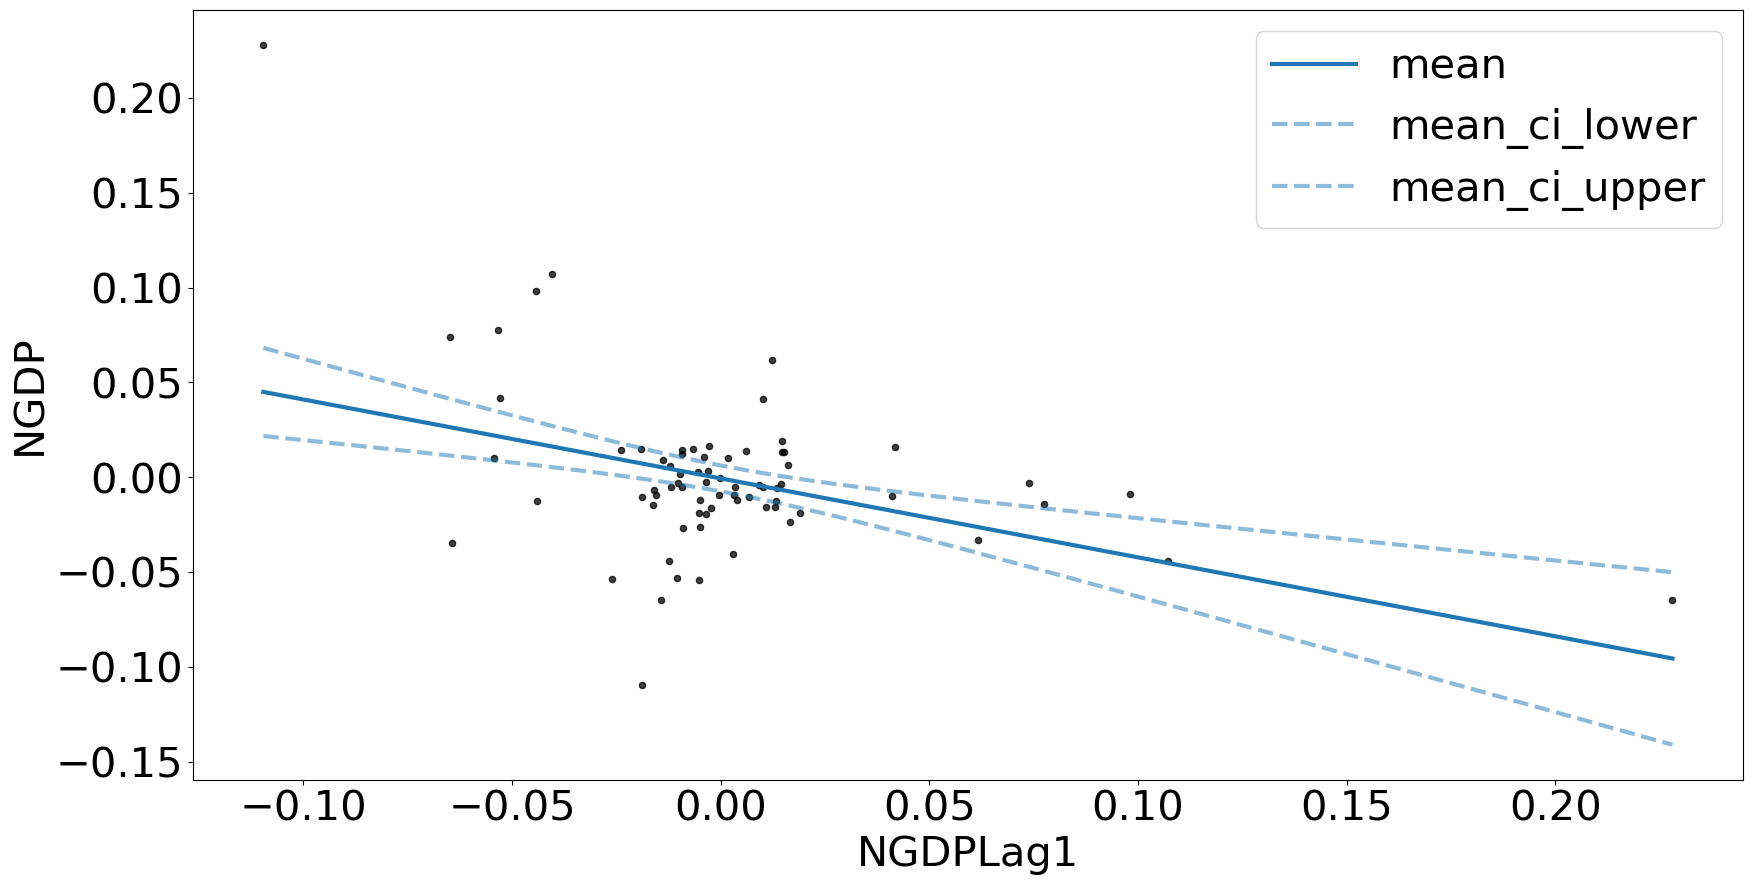

In [14]:
# fig, ax = plt.subplots(figsize = (20,20))
plot_vars = ["NGDP",  "EFFR", "UST10Y", "C", "B","A"]
# annual_rate["FRAssets"].fillna(0, inplace = True)
plot_df = rate_data.diff(freq)[plot_vars].loc["2004":].dropna()
formula = 'NGDP ~  C + EFFR + UST10Y + B + A'

for key in plot_df:
    for i in range(1, lags + 1):
        plot_df[key + "Lag" + str(i)] = plot_df[key].shift(freq * i)
        formula = formula + " + NGDPLag" + str(i) 
        
# plot_df.plot.scatter(y = "NGDP", x = "EFFR", ax = ax)
# y = plot_df[[plot_vars[0]]]
# X = plot_df[plot_vars[1:]]
# X["Constant"] = 1
# reg = sm.OLS(y, X)
reg = smf.ols(
    formula=formula,
    data = plot_df)
results = reg.fit()
print(results.summary())
build_smooth_multiple_regression_estimator(reg, plot_df)
plot_df[plot_vars + ["NGDPLag" + str(i) for i in range(1, lags + 1)]].pcorr()


C:\Users\JLCat\AppData\Local\Temp\ipykernel_33760\1319502352.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(y)) + "%" for y in ax.get_yticks()], color = "C0", fontsize = 40)
C:\Users\JLCat\AppData\Local\Temp\ipykernel_33760\1319502352.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(y)) + "%" for y in ax2.get_yticks()], color = "C0", alpha = alpha2, fontsize = 40)


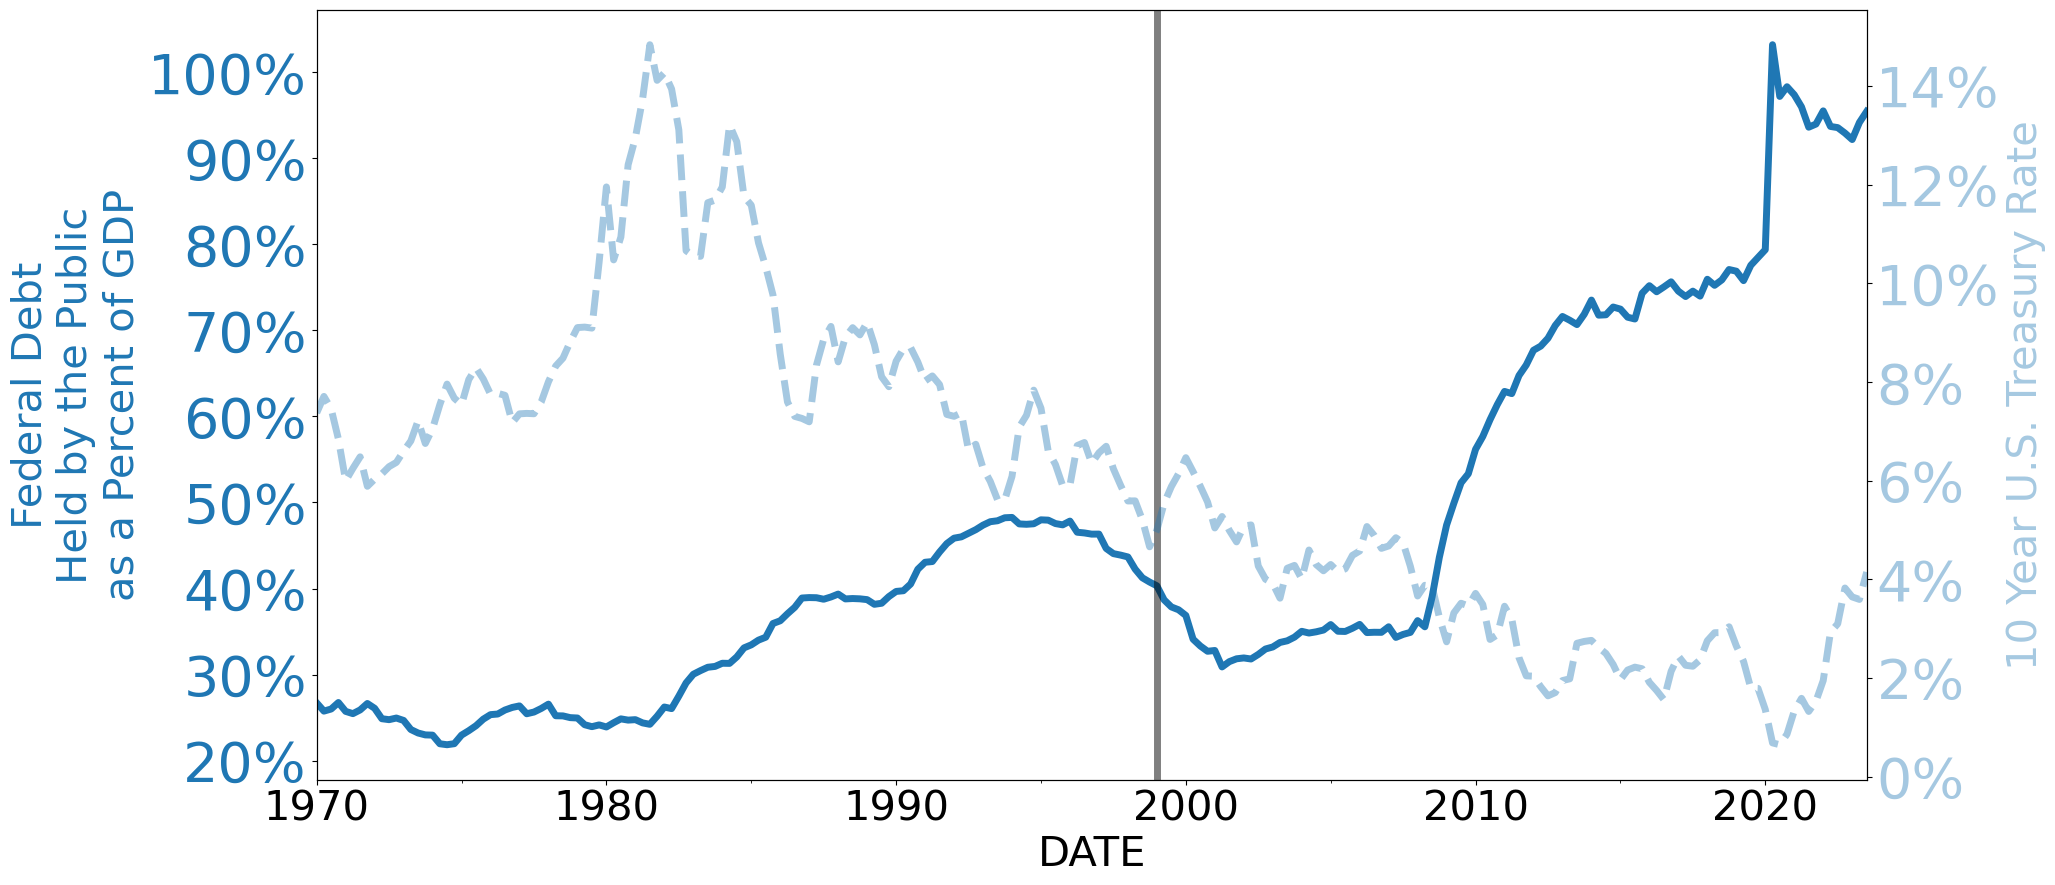

In [15]:
fig, ax = plt.subplots(figsize = (20,10))
ax2 = ax.twinx()
alpha2 = .4
rate_data["$\\frac{Debt}{GDP}$"].mul(100).dropna().plot.line(linewidth = 5, 
                                            ax = ax)
rate_data.dropna(subset = "$\\frac{Debt}{GDP}$")["UST10Y"].mul(100).plot.line(linewidth = 5,
                                                                color = "C0",
                                                                ls = "--",
                                                                alpha = alpha2,
                                                                ax = ax2)
ax.set_yticklabels([str(int(y)) + "%" for y in ax.get_yticks()], color = "C0", fontsize = 40)
ax2.set_yticklabels([str(int(y)) + "%" for y in ax2.get_yticks()], color = "C0", alpha = alpha2, fontsize = 40)
ax.set_ylabel("Federal Debt\nHeld by the Public\nas a Percent of GDP", color = "C0")
ax2.set_ylabel("10 Year U.S. Treasury Rate", alpha = alpha2, color = "C0")
# ax.axhline(data["$\\frac{Debt}{GDP}$"].dropna().iloc[-1], ls = "--", color = "k", linewidth = 5, alpha = .3)
ax.axvline("1999", ls = "-", color = "k", linewidth = 5, alpha = .5)

In [16]:
data["$\\frac{Debt}{GDP}$"].loc["1990":].min(), data["$\\frac{Debt}{GDP}$"].loc["1990":].max(), data["$\\frac{Debt}{GDP}$"].iloc[-2]

KeyError: '$\\frac{Debt}{GDP}$'

In [ ]:
rate_data